In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
sns.set_theme()

In [41]:
llm_map = {
    'id': 'id', 
        'CV': 'No Manipulation', 
    'Claude-3.5-Sonnet': 'Claude-3.5-Sonnet', 
    'Clean_Deepseek_67B': 'DeepSeek-67B',
    'Clean_Deepseek_V3': 'DeepSeek-V3',
    'GPT-3.5-Turbo': 'GPT-3.5-Turbo', 
    'GPT4o-mini': 'GPT4o-mini', 
     'GPT4o':  'GPT4o', 
    'Llama3-70B-Instruct-Turbo': 'Llama3-70B-Instruct-Turbo', 
    'Mixtral-8x7B-Instruct': 'Mixtral-8x7B-Instruct', 
}

job_map = {
    'DD_PM': 'DoorDash Product Manager', 
    'Apple_PM': 'Apple Product Manager', 
    'Match_PM': 'Match Product Manager', 
    'Samsara_PM': 'Samsara Product Manager', 
    'Yelp_PM': 'Yelp Product Manager',
    'Adobe_UX': 'Adobe UX Designer', 
    'Amazon_UX': 'Amazon UX Designer', 
    'Google_UX': 'Google UX Designer', 
    'I2C_UX': 'I2C UX Designer', 
    'Rowan_UX': 'Rowan UX Designer', 
}

models_list = ['No Manipulation', 'Claude-3.5-Sonnet', 'DeepSeek-67B', 'DeepSeek-V3',
               'GPT-3.5-Turbo', 'GPT4o-mini', 'GPT4o','Llama3-70B-Instruct-Turbo', 'Mixtral-8x7B-Instruct']

In [4]:
# single plot
job_str = 'Adobe_UX'
scores_df = pd.read_csv(f'Figure1_100Samples/Scores/Scores-{job_str}-Resumes.csv')

In [5]:
scores_df.columns = scores_df.columns.str.rsplit(' ', n=2).str[0]
scores_df.columns = scores_df.columns.map(llm_map)

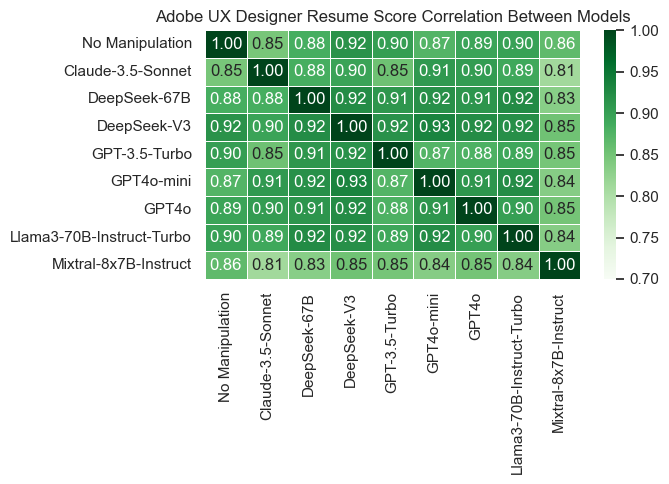

In [6]:
corr_matrix = scores_df[models_list].corr()
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="Greens", 
            fmt=".2f", linewidths=.5,
            vmin=0.7, vmax=1).set_title(f"{job_str} Resume Corr")
plt.title(f"{job_map[job_str]} Resume Score Correlation Between Models")
plt.tight_layout()
plt.savefig(f"img/{job_str}_model_corr.pdf")
plt.show()

In [8]:
scores_df['True Label'] = scores_df['id']>49
scores_df['True Label'] = scores_df['True Label'].astype(int)

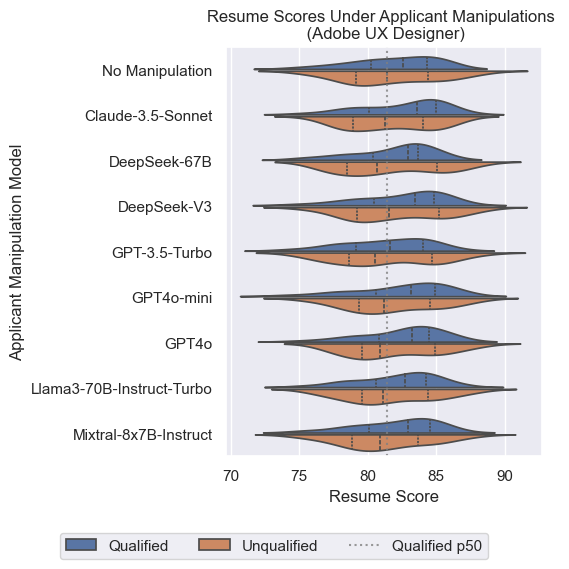

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
melted_df = pd.melt(scores_df, 
                    # Keep b and i as id variables
                    id_vars=['True Label'],
                    # Select the CR columns to melt
                    value_vars=models_list,
                    # Name the new columns
                    var_name='LLM',
                    value_name='Resume Score')

melted_df['Ground Truth'] = melted_df['True Label'].map({1:'Unqualified', 0:'Qualified'})
qualified_mean = scores_df[scores_df['True Label'] == 1]['No Manipulation'].median()
sns.violinplot(data=melted_df, x='Resume Score', y='LLM', 
               hue='Ground Truth', split='true', 
               hue_order=['Qualified', 'Unqualified'], 
               inner='quart', gap=0.1)
plt.axvline(x=qualified_mean, color='gray', linestyle=':', alpha=0.8, label='Qualified p50')
plt.ylabel('Applicant Manipulation Model')
plt.title(f"Resume Scores Under Applicant Manipulations \n ({job_map[job_str]})")
plt.legend(bbox_to_anchor=(-0.55, -0.27), loc='lower left', ncol=3)
plt.tight_layout()
plt.savefig(f"img/{job_str}_1round.pdf")

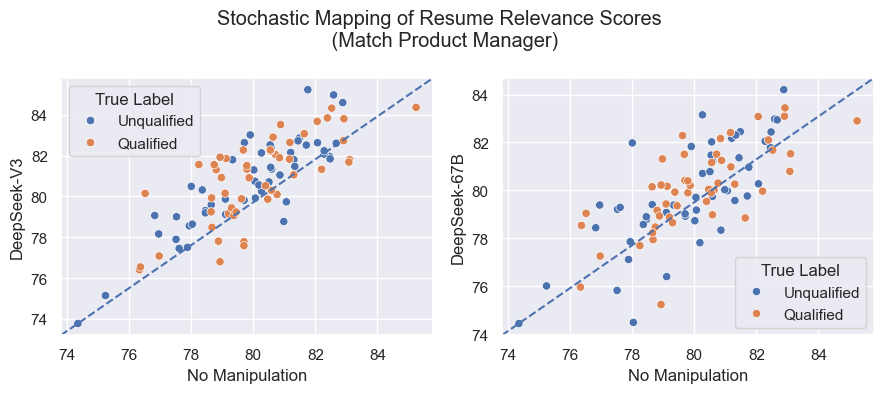

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes = axes.flatten() 
sns.scatterplot(x=scores_df['No Manipulation'],  
                y=scores_df['DeepSeek-V3'], 
                ax=axes[0], 
                hue=scores_df['True Label'].map({0:'Unqualified', 1:'Qualified'}))
axes[0].plot([0, 1], [0, 1], transform=axes[0].transAxes, linestyle='--', label="No Change")
sns.scatterplot(x=scores_df['No Manipulation'],  
                y=scores_df['DeepSeek-67B'], 
                ax=axes[1], 
                hue=scores_df['True Label'].map({0:'Unqualified', 1:'Qualified'}))
axes[1].plot([0, 1], [0, 1], transform=axes[1].transAxes, linestyle='--', label="No Change")
plt.suptitle(f"Stochastic Mapping of Resume Relevance Scores \n ({job_map[job_str]})")
fig.tight_layout()
plt.savefig(f"img/{job_str}_mapping.pdf")

## Resume Distances

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
emb_map = {'original.npy':'No Manipulation',  
           'claude-3-5-sonnet.npy': 'Claude-3.5-Sonnet',
           'deepseek67b.npy': 'DeepSeek-67B',
           'deepseek_v3.npy': 'DeepSeek-V3',
           'gpt-35-turbo.npy': 'GPT-3.5-Turbo',
           'gpt4omini.npy': 'GPT4o-mini',
           'gpt4o.npy': 'GPT4o',
           'metallama.npy': 'Llama3-70B-Instruct-Turbo', 
           'mixtral.npy': 'Mixtral-8x7B-Instruct', 
          }

In [40]:
df_list = [] 
for filename in emb_map.keys(): 
    df = pd.DataFrame()
    emb = np.load(f"Figure1_100Samples/Embeddings/{filename}")
    # remove 28 and 60 
    ind = [i for i in range(len(emb)) if i !=28 and i != 60]
    emb=emb[ind]
    sim_mat = cosine_similarity(emb, emb)
    sim_arr = sim_mat[np.triu_indices(len(emb), k=1)]
    df['sim'] = sim_arr
    df['model'] = filename
    df_list.append(df)

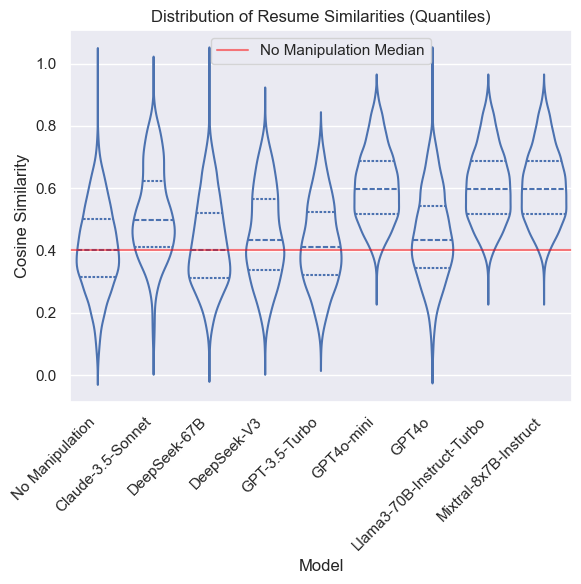

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))

all_sim = pd.concat(df_list)
all_sim['model'] = all_sim['model'].map(emb_map)
sns.violinplot(data=all_sim, x='model', y='sim', fill=False, inner='quart')
median=all_sim[all_sim['model'] == 'No Manipulation']['sim'].median()
plt.axhline(y=median, color='red', alpha=0.5, label='No Manipulation Median')
plt.xlabel("Model")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Resume Similarities (Quantiles)")
plt.legend()
plt.tight_layout()
plt.savefig("img/resume-similarity.pdf")

## Two Manipulations vs One Manipulation

In [ ]:
#cel of original code
manipulation_dd_map = {
       ' claude-3-5-sonnet Conversation-Improved CV DoorDash PM Score': 1,
       ' Twice claude-3-5-sonnet Conversation-Improved CV DoorDash PM Score': 2,
       ' Deepseek 67B Conversation-Improved CV DoorDash PM Score': 1, 
       ' Twice Deepseek 67B Conversation-Improved CV DoorDash PM Score': 2, 
       ' GPT-35 Conversation-Improved CV DoorDash PM Score': 1, 
       ' Twice GPT-35 Conversation-Improved CV DoorDash PM Score':2, 
       ' GPT-4o Conversation-Improved CV DoorDash PM Score': 1, 
       ' Twice GPT-4o Conversation-Improved CV DoorDash PM Score': 2, 
       ' Meta-Llama-3-70B-Instruct-Turbo Conversation-Improved CV DoorDash PM Score': 1,
       ' Twice Meta-Llama-3-70B-Instruct-Turbo Conversation-Improved CV DoorDash PM Score': 2,}

manipulation_scalable_map = {
       ' claude-3-5-sonnet Conversation-Improved CV Scalable PM Score': 1,
       ' Twice claude-3-5-sonnet Conversation-Improved CV Scalable PM Score': 2,
       ' Deepseek 67B Conversation-Improved CV Scalable PM Score': 1, 
       ' Twice Deepseek 67B Conversation-Improved CV Scalable PM Score': 2, 
       ' GPT-35 Conversation-Improved CV Scalable PM Score': 1, 
       ' Twice GPT-35 Conversation-Improved CV Scalable PM Score':2, 
       ' GPT-4o Conversation-Improved CV Scalable PM Score': 1, 
       ' Twice GPT-4o Conversation-Improved CV Scalable PM Score': 2, 
       ' Meta-Llama-3-70B-Instruct-Turbo Conversation-Improved CV Scalable PM Score': 1,
       ' Twice Meta-Llama-3-70B-Instruct-Turbo Conversation-Improved CV Scalable PM Score': 2,}

In [ ]:
#cel of original code
melted_df = pd.melt(doordash_df, 
                    # Keep b and i as id variables
                    id_vars=['True Label'],
                    # Select the CR columns to melt
                    value_vars=manipulation_dd_map.keys(),
                    # Name the new columns
                    var_name='LLM',
                    value_name='Resume Score')
melted_df['LLM Name'] = melted_df['LLM'].map(llm_map)
melted_df['Num Manipulations'] = melted_df['LLM'].map(manipulation_dd_map)

sns.set_theme()
sns.violinplot(data=melted_df, x='Resume Score', y='LLM Name', 
               hue='Num Manipulations', split='true', inner='quart', 
               fill=False,  palette={1: "g", 2: ".35"})
plt.ylabel('Applicant Manipulation Model')
plt.title("Resume Scores Under 1 or 2 Manipulations \n (DoorDash)")
plt.legend(bbox_to_anchor=(-0.42, -0.18), loc='lower left')
plt.tight_layout()
#plt.savefig("img/doordash_pm_1vs2rounds.pdf")

KeyError: "The following id_vars or value_vars are not present in the DataFrame: [' claude-3-5-sonnet CV UI/UX PM Score', ' Twice claude-3-5-sonnet CV UI/UX PM Score', ' Deepseek 67B CV UI/UX PM Score', ' Twice Deepseek 67B CV UI/UX PM Score', ' GPT-35 CV UI/UX PM Score', ' Twice GPT-35 CV UI/UX PM Score', ' Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score', ' Twice Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score', ' Mixtral CV UI/UX PM Score', ' Twice Mixtral CV UI/UX PM Score']"

In [62]:
'''Code to combine all models in one dataframe (*DoorDashPMScores.csv* in original files'''

llm_map = {
    "id": "id",
    "CV": "No Manipulation",

    # Claude
    " claude-3-5-sonnet CV UI/UX PM Score": "Claude-3.5-Sonnet",
    " Twice claude-3-5-sonnet CV UI/UX PM Score": "Claude-3.5-Sonnet",

    # DeepSeek 67B
    " Deepseek 67B CV UI/UX PM Score": "DeepSeek-67B",
    " Twice Deepseek 67B CV UI/UX PM Score": "DeepSeek-67B",

    # GPT 3.5
    " GPT-35 CV UI/UX PM Score": "GPT-3.5-turbo",
    " Twice GPT-35 CV UI/UX PM Score": "GPT-3.5-turbo",

    # Llama 3 70B
    " Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score": "Llama3-70B-Instruct-Turbo",
    " Twice Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score": "Llama3-70B-Instruct-Turbo",

    # Mixtral
    " Mixtral CV UI/UX PM Score": "Mixtral-8x7B-Instruct",
    " Twice Mixtral CV UI/UX PM Score": "Mixtral-8x7B-Instruct",
}

manipulation_dd_map = {
       ' claude-3-5-sonnet CV UI/UX PM Score': 1,
       ' Twice claude-3-5-sonnet CV UI/UX PM Score': 2,
       ' Deepseek 67B CV UI/UX PM Score': 1, 
       ' Twice Deepseek 67B CV UI/UX PM Score': 2, 
       ' GPT-35 CV UI/UX PM Score': 1, 
       ' Twice GPT-35 CV UI/UX PM Score':2, 
       ' Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score': 1,
       ' Twice Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score': 2,
       ' Mixtral CV UI/UX PM Score': 1,
       ' Twice Mixtral CV UI/UX PM Score': 2,
}

files = {
    ' claude-3-5-sonnet CV UI/UX PM Score':  "outdir/scores/anthropic_claude_sonnet-4-20250514/ScoresGoogle_UX_Original_File_file_2026-01-20_20-29.csv",
    ' Twice claude-3-5-sonnet CV UI/UX PM Score':  "outdir/scores/anthropic_claude_sonnet-4-20250514/ScoresGoogle_UX_Original_File_file_2026-01-20_20-29.csv",
    ' Deepseek 67B CV UI/UX PM Score':  "outdir/scores/deepseek_deepseek-chat/ScoresGoogle_UX_Original_File_file_2026-01-17_17-22.csv", 
    ' Twice Deepseek 67B CV UI/UX PM Score': "outdir/scores/deepseek_deepseek-chat/ScoresGoogle_UX_Original_File_file_2026-01-17_17-22.csv", 
    ' GPT-35 CV UI/UX PM Score': "outdir/scores/openai_gpt-3.5-turbo/ScoresGoogle_UX_Original_File_file_2026-01-19_12-34.csv", 
    ' Twice GPT-35 CV UI/UX PM Score': "outdir/scores/openai_gpt-3.5-turbo/ScoresGoogle_UX_Original_File_file_2026-01-19_12-34.csv", 
    ' Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score': "outdir/scores/together_meta-llama/ScoresGoogle_UX_Original_File_file_2026-01-19_19-37.csv",
    ' Twice Meta-Llama-3-70B-Instruct-Turbo CV UI/UX PM Score': "outdir/scores/together_meta-llama/ScoresGoogle_UX_Original_File_file_2026-01-19_19-37.csv",
    ' Mixtral CV UI/UX PM Score': "outdir/scores/together_meta-llama/ScoresGoogle_UX_Original_File_file_2026-01-19_19-37.csv",
    ' Twice Mixtral CV UI/UX PM Score': "outdir/scores/together_mistralai/ScoresGoogle_UX_Original_File_file_2026-01-19_14-02.csv",
}

merged_df = None
for name, f in files.items():
    df = pd.read_csv(f, index_col=0)
    df.index.name = "id"
    df = df.reset_index()
    
    # assume remaining column is the score
    score_col = df.columns.difference(["id"])[0]
    df = df[["id", score_col]].rename(columns={score_col: name})

    if merged_df is None:
        merged_df = df
    else:
        merged_df = merged_df.merge(df, on="id", how="inner")

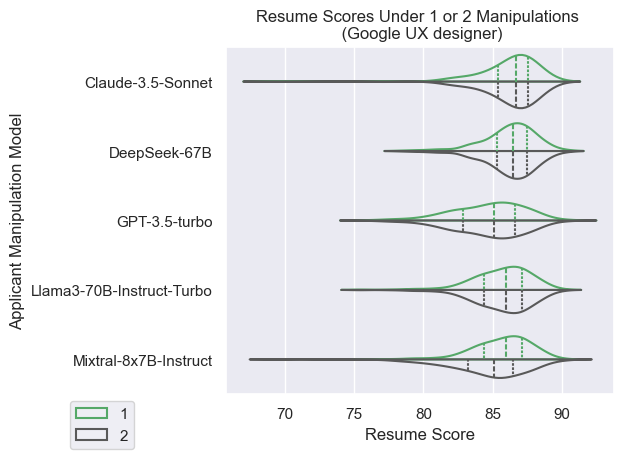

In [63]:
melted_df = pd.melt(merged_df, 
                    # Keep b and i as id variables
                    id_vars=['id'],
                    # Select the CR columns to melt
                    value_vars=manipulation_dd_map.keys(),
                    # Name the new columns
                    var_name='LLM',
                    value_name='Resume Score')
melted_df['LLM Name'] = melted_df['LLM'].map(llm_map)
melted_df['Num Manipulations'] = melted_df['LLM'].map(manipulation_dd_map)

sns.set_theme()
sns.violinplot(data=melted_df, x='Resume Score', y='LLM Name', 
               hue='Num Manipulations', split=True, inner='quart', 
               fill=False,  palette={1: "g", 2: ".35"})
plt.ylabel('Applicant Manipulation Model')
plt.title("Resume Scores Under 1 or 2 Manipulations \n (Google UX designer)")
plt.legend(bbox_to_anchor=(-0.42, -0.18), loc='lower left')
plt.tight_layout()
plt.show()
#plt.savefig("img/doordash_pm_1vs2rounds.pdf")

In [45]:
import os

os.listdir("Figure1_100Samples/Scores")


['Scores-Samsara_PM-Resumes.csv',
 'Scores-Yelp_PM-Resumes.csv',
 'Scores-DD_PM-Resumes.csv',
 'Scores-I2C_UX-Resumes.csv',
 'google_ux_job_description.csv',
 'Scores-Google_UX-Resumes.csv',
 'Scores-Adobe_UX-Resumes.csv',
 'Scores-Rowan_UX-Resumes.csv',
 'Scores-Amazon_UX-Resumes.csv',
 'Scores-Apple_PM-Resumes.csv',
 'Scores-Match_PM-Resumes.csv',
 'doordash_job_description.csv']

In [ ]:
'''no idea what this is, i dont think it was in the original code'''
scalable_df = pd.read_csv(
    "Figure1_100Samples/Scores/Scores-Samsara_PM-Resumes.csv"
)
scalable_df['True Label'] = scalable_df['True Label'].astype(int)
# sanity check: make sure columns exist
missing_cols = set(manipulation_scalable_map.keys()) - set(scalable_df.columns)
assert len(missing_cols) == 0, f"Missing columns: {missing_cols}"

melted_scalable = pd.melt(
    scalable_df,
    id_vars=['True Label'],
    value_vars=list(manipulation_scalable_map.keys()),
    var_name='LLM',
    value_name='Resume Score'
)

melted_scalable['LLM Name'] = melted_scalable['LLM'].map(llm_map)
melted_scalable['Num Manipulations'] = melted_scalable['LLM'].map(manipulation_scalable_map)

# critical safety check
assert len(melted_scalable) > 0, "melted_scalable is empty"

sns.set_theme()
sns.violinplot(
    data=melted_scalable,
    x='Resume Score',
    y='LLM Name',
    hue='Num Manipulations',
    split=True,              # boolean, not string
    inner='quart',
    fill=False,
    palette={1: "g", 2: ".35"}
)

plt.ylabel('Applicant Manipulation Model')
plt.title("Resume Scores Under 1 or 2 Manipulations \n (Scalable PM)")
plt.legend(bbox_to_anchor=(-0.42, -0.18), loc='lower left')
plt.tight_layout()
plt.savefig("img/scalable_pm_1vs2rounds.pdf")



KeyError: 'True Label'